In [1]:
import logging
import sys
import os

import zipfile

import importlib

from six.moves import urllib
from shutil import copy2

import matplotlib.pyplot as plt

import cv2

import numpy as np

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

In [8]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator

In [19]:
batch_size = 128
num_classes = 2
epochs = 10

# input image dimensions
img_rows, img_cols = 48, 48

In [4]:
def download(url, dest_directory):
    filename = url.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)

    logging.info("Download URL: {}".format(url))
    logging.info("Download DIR: {}".format(dest_directory))

    def _progress(count, block_size, total_size):
                prog = float(count * block_size) / float(total_size) * 100.0
                sys.stdout.write('\r>> Downloading %s %.1f%%' %
                                 (filename, prog))
                sys.stdout.flush()

    filepath, _ = urllib.request.urlretrieve(url, filepath,
                                             reporthook=_progress)
    print()
    return filepath


importlib.reload(logging)
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# Download KITTI DATA

kitti_data_url = 'https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip'

data_dir = './data'

data_road_zip = './data/data_road.zip'


if not os.path.exists(data_road_zip):
    if kitti_data_url == '':
        logging.error("Data URL for Kitti Data not provided.")
        url = "http://www.cvlibs.net/download.php?file=data_road.zip"
        logging.error("Please visit: {}".format(url))
        logging.error("and request Kitti Download link.")
        exit(1)
    if not kitti_data_url[-19:] == 'kitti/data_road.zip':
        logging.error("Wrong url.")
        url = "http://www.cvlibs.net/download.php?file=data_road.zip"
        logging.error("Please visit: {}".format(url))
        logging.error("and request Kitti Download link.")
        exit(1)
    else:
        logging.info("Downloading Kitti Road Data.")
        download(kitti_data_url, data_dir)

# Extract and prepare KITTI DATA
logging.info("Extracting kitti_road data.")
zipfile.ZipFile(data_road_zip, 'r').extractall(data_dir)
kitti_road_dir = os.path.join(data_dir, 'data_road/')


train_txt = "data/train3.txt"
val_txt = "data/val3.txt"
testing_txt = "data/testing.txt"

sys.stdout.flush()

INFO:root:Extracting kitti_road data.


In [5]:
def getData(txt):
    all_x = []
    all_y = []

    with open(txt, 'r') as f:
        for line in f:
            sys.stdout.write('\r>> Processing %s          ' % (line.rstrip()))
            sys.stdout.flush()
            
            names = line.split()

            # load the image and apply SLIC and extract (approximately)
            image = cv2.imread(os.path.join(kitti_road_dir, names[0]))
            segments = slic(img_as_float(image), n_segments = 200, sigma = 5)

            image2 = cv2.imread(os.path.join(kitti_road_dir, names[1]))
            magenta = np.array([255, 0, 255], dtype=np.uint8)

            mask2 = np.all(image2 == magenta, axis = -1)

            # loop over the unique segment values
            for (i, segVal) in enumerate(np.unique(segments)):
                # construct a mask for the segment
                mask = np.zeros(image.shape[:2], dtype = "uint8")
                mask[segments == segVal] = 255

                m = cv2.moments(mask, True);

                x = m["m10"]/m["m00"]
                y = m["m01"]/m["m00"]

                intersection = np.logical_and(mask, mask2)

                img = cv2.bitwise_and(image, image, mask = mask)

                #crop
                img = img[int(y - img_rows/2) : int(y + img_rows/2), 
                          int(x - img_cols/2) : int(x + img_cols/2)]

                old_size = img.shape[:2]
                delta_w = img_cols - old_size[1]#img.cols
                delta_h = img_rows - old_size[0]#img.rows
                top, bottom = delta_h//2, delta_h-(delta_h//2)
                left, right = delta_w//2, delta_w-(delta_w//2)

                img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)


                value = int(np.sum(intersection) > m["m00"] / 2)

                all_x.append([img])
                all_y.append([value])

                #flipHorizontal = cv2.flip(img, 1)
                #all_x.append([flipHorizontal])
                #all_y.append([value])

    all_x = np.concatenate(all_x)
    all_y = np.concatenate(all_y)

    return all_x, all_y

In [10]:
# the data, split between train and test sets
(x_train, y_train) = getData(train_txt)
(x_test, y_test) = getData(val_txt)

>> Processing training/image_2/uu_000097.png training/gt_image_2/uu_road_000097.png            

In [11]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (43580, 48, 48, 3)
y_train shape: (43580,)
43580 train samples
8668 test samples


In [25]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

#model.fit(x_train, y_train,
#          batch_size=batch_size,
#          epochs=epochs,
#          verbose=1,
#          validation_data=(x_test, y_test))

# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
        height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
        #does not work: https://github.com/keras-team/keras/issues/10366
        #brightness_range=(1.0,1.1),
        horizontal_flip=True, fill_mode="constant", cval=0)

# train the network
H = model.fit_generator(aug.flow(x_train, y_train, batch_size=batch_size),
        validation_data=(x_test, y_test),
        steps_per_epoch=len(x_train) // epochs,
        epochs=epochs, verbose=1)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
4358/4358 [==============================] - 312s 72ms/step - loss: 0.1715 - accuracy: 0.9264 - val_loss: 0.2116 - val_accuracy: 0.9290
Epoch 2/10
4358/4358 [==============================] - 312s 72ms/step - loss: 0.1399 - accuracy: 0.9425 - val_loss: 0.1942 - val_accuracy: 0.9413
Epoch 3/10
4358/4358 [==============================] - 310s 71ms/step - loss: 0.1283 - accuracy: 0.9480 - val_loss: 0.2067 - val_accuracy: 0.9498
Epoch 4/10
4358/4358 [==============================] - 311s 71ms/step - loss: 0.1173 - accuracy: 0.9528 - val_loss: 0.2256 - val_accuracy: 0.9476
Epoch 5/10
4358/4358 [==============================] - 313s 72ms/step - loss: 0.1093 - accuracy: 0.9559 - val_loss: 0.2206 - val_accuracy: 0.9415
Epoch 6/10
4358/4358 [==============================] - 311s 71ms/step - loss: 0.1026 - accuracy: 0.9586 - val_loss: 0.2508 - val_accuracy: 0.9552
Epoch 7/10
4358/4358 [==============================] - 310s 71ms/step - loss: 0.0977 - accuracy: 0.9606 - val_loss: 0

In [26]:
model.save('my_model.h5')

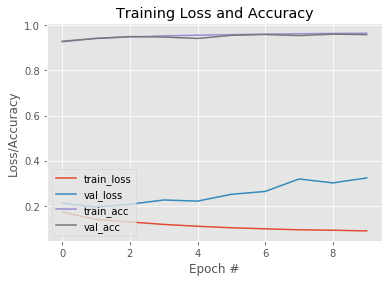

In [27]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")